In [1]:
!pip install --no-cache-dir torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install --no-cache-dir torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install --no-cache-dir torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install --no-cache-dir torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install --no-cache-dir torch-geometric
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
     |████████████████████████████████| 2.6MB 8.1MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
     |████████████████████████████████| 1.5MB 6.8MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
     |████████████████████████████████| 1.0MB 8.9MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
     |████████████████████████████████| 389kB 7.1MB/s 
     |████████████████████████████████| 194kB 8.9MB/s 
     |████████████████████████████████| 235kB 15.7MB/s 
     |████████████████████████████████| 2.2MB 18.0MB/s 
     |████████████████████████████████| 51kB 45.8MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.6.3-cp37-none-any.whl size=322719 sha256=31b69a3db87dac1f5007835cfe86dca344b71545755fe4cbe7af82dd6673c792
  Stored in directory: /tmp/pip-ephem-wheel-cache-bzvu7gyr/wheels/6d/47/1e/0af8ce3e21783

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import networkx as nx
import numpy as np
import pickle as pkl
import scipy.sparse as sp
import torch.utils.data
import torch.nn.functional as F
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score
import itertools
from collections import Counter
from random import shuffle
import json

from networkx.readwrite import json_graph
from argparse import ArgumentParser
import matplotlib.pyplot as plt

import pdb
import time
import random
import pickle
import os.path
import torch_geometric as tg
import torch_geometric.datasets
import time

from torch_geometric.data import Data, DataLoader

In [4]:
class GATLayer(torch.nn.Module):
    """
    Implementation #3 was inspired by PyTorch Geometric: https://github.com/rusty1s/pytorch_geometric

    But, it's hopefully much more readable! (and of similar performance)

    """
    
    # We'll use these constants in many functions so just extracting them here as member fields
    src_nodes_dim = 0  # position of source nodes in edge index
    trg_nodes_dim = 1  # position of target nodes in edge index

    # These may change in the inductive setting - leaving it like this for now (not future proof)
    nodes_dim = 0      # node dimension (axis is maybe a more familiar term nodes_dim is the position of "N" in tensor)
    head_dim = 1       # attention head dim

    def __init__(self, num_in_features, num_out_features, num_of_heads, concat=True, activation=nn.ELU(),
                 dropout_prob=0.6, add_skip_connection=True, bias=True, log_attention_weights=False):

        super().__init__()

        self.num_of_heads = num_of_heads
        self.num_out_features = num_out_features
        self.concat = concat  # whether we should concatenate or average the attention heads
        self.add_skip_connection = add_skip_connection

        #
        # Trainable weights: linear projection matrix (denoted as "W" in the paper), attention target/source
        # (denoted as "a" in the paper) and bias (not mentioned in the paper but present in the official GAT repo)
        #

        # You can treat this one matrix as num_of_heads independent W matrices
        self.linear_proj = nn.Linear(num_in_features, num_of_heads * num_out_features, bias=False)

        # After we concatenate target node (node i) and source node (node j) we apply the "additive" scoring function
        # which gives us un-normalized score "e". Here we split the "a" vector - but the semantics remain the same.
        # Basically instead of doing [x, y] (concatenation, x/y are node feature vectors) and dot product with "a"
        # we instead do a dot product between x and "a_left" and y and "a_right" and we sum them up
        self.scoring_fn_target = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features))
        self.scoring_fn_source = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features))

        # Bias is definitely not crucial to GAT - feel free to experiment (I pinged the main author, Petar, on this one)
        if bias and concat:
            self.bias = nn.Parameter(torch.Tensor(num_of_heads * num_out_features))
        elif bias and not concat:
            self.bias = nn.Parameter(torch.Tensor(num_out_features))
        else:
            self.register_parameter('bias', None)

        if add_skip_connection:
            self.skip_proj = nn.Linear(num_in_features, num_of_heads * num_out_features, bias=False)
        else:
            self.register_parameter('skip_proj', None)

        #
        # End of trainable weights
        #

        self.leakyReLU = nn.LeakyReLU(0.2)  # using 0.2 as in the paper, no need to expose every setting
        self.activation = activation
        # Probably not the nicest design but I use the same module in 3 locations, before/after features projection
        # and for attention coefficients. Functionality-wise it's the same as using independent modules.
        self.dropout = nn.Dropout(p=dropout_prob)

        self.log_attention_weights = log_attention_weights  # whether we should log the attention weights
        self.attention_weights = None  # for later visualization purposes, I cache the weights here

        self.init_params()
        
    def forward(self, data):
        #
        # Step 1: Linear Projection + regularization
        #

        in_nodes_features, edge_index = data  # unpack data
        num_of_nodes = in_nodes_features.shape[self.nodes_dim]
        assert edge_index.shape[0] == 2, f'Expected edge index with shape=(2,E) got {edge_index.shape}'

        # shape = (N, FIN) where N - number of nodes in the graph, FIN - number of input features per node
        # We apply the dropout to all of the input node features (as mentioned in the paper)
        in_nodes_features = self.dropout(in_nodes_features)

        # shape = (N, FIN) * (FIN, NH*FOUT) -> (N, NH, FOUT) where NH - number of heads, FOUT - num of output features
        # We project the input node features into NH independent output features (one for each attention head)
        nodes_features_proj = self.linear_proj(in_nodes_features).view(-1, self.num_of_heads, self.num_out_features)

        nodes_features_proj = self.dropout(nodes_features_proj)  # in the official GAT imp they did dropout here as well

        #
        # Step 2: Edge attention calculation
        #

        # Apply the scoring function (* represents element-wise (a.k.a. Hadamard) product)
        # shape = (N, NH, FOUT) * (1, NH, FOUT) -> (N, NH, 1) -> (N, NH) because sum squeezes the last dimension
        # Optimization note: torch.sum() is as performant as .sum() in my experiments
        scores_source = (nodes_features_proj * self.scoring_fn_source).sum(dim=-1)
        scores_target = (nodes_features_proj * self.scoring_fn_target).sum(dim=-1)

        # We simply copy (lift) the scores for source/target nodes based on the edge index. Instead of preparing all
        # the possible combinations of scores we just prepare those that will actually be used and those are defined
        # by the edge index.
        # scores shape = (E, NH), nodes_features_proj_lifted shape = (E, NH, FOUT), E - number of edges in the graph
        scores_source_lifted, scores_target_lifted, nodes_features_proj_lifted = self.lift(scores_source, scores_target, nodes_features_proj, edge_index)
        scores_per_edge = self.leakyReLU(scores_source_lifted + scores_target_lifted)

        # shape = (E, NH, 1)
        attentions_per_edge = self.neighborhood_aware_softmax(scores_per_edge, edge_index[self.trg_nodes_dim], num_of_nodes)
        # Add stochasticity to neighborhood aggregation
        attentions_per_edge = self.dropout(attentions_per_edge)

        #
        # Step 3: Neighborhood aggregation
        #

        # Element-wise (aka Hadamard) product. Operator * does the same thing as torch.mul
        # shape = (E, NH, FOUT) * (E, NH, 1) -> (E, NH, FOUT), 1 gets broadcast into FOUT
        nodes_features_proj_lifted_weighted = nodes_features_proj_lifted * attentions_per_edge

        # This part sums up weighted and projected neighborhood feature vectors for every target node
        # shape = (N, NH, FOUT)
        out_nodes_features = self.aggregate_neighbors(nodes_features_proj_lifted_weighted, edge_index, in_nodes_features, num_of_nodes)

        #
        # Step 4: Residual/skip connections, concat and bias
        #

        out_nodes_features = self.skip_concat_bias(attentions_per_edge, in_nodes_features, out_nodes_features)
        return (out_nodes_features, edge_index)

    #
    # Helper functions (without comments there is very little code so don't be scared!)
    #

    def neighborhood_aware_softmax(self, scores_per_edge, trg_index, num_of_nodes):
        """
        As the fn name suggest it does softmax over the neighborhoods. Example: say we have 5 nodes in a graph.
        Two of them 1, 2 are connected to node 3. If we want to calculate the representation for node 3 we should take
        into account feature vectors of 1, 2 and 3 itself. Since we have scores for edges 1-3, 2-3 and 3-3
        in scores_per_edge variable, this function will calculate attention scores like this: 1-3/(1-3+2-3+3-3)
        (where 1-3 is overloaded notation it represents the edge 1-3 and its (exp) score) and similarly for 2-3 and 3-3
         i.e. for this neighborhood we don't care about other edge scores that include nodes 4 and 5.

        Note:
        Subtracting the max value from logits doesn't change the end result but it improves the numerical stability
        and it's a fairly common "trick" used in pretty much every deep learning framework.
        Check out this link for more details:

        https://stats.stackexchange.com/questions/338285/how-does-the-subtraction-of-the-logit-maximum-improve-learning

        """
        # Calculate the numerator. Make logits <= 0 so that e^logit <= 1 (this will improve the numerical stability)
        scores_per_edge = scores_per_edge - scores_per_edge.max()
        exp_scores_per_edge = scores_per_edge.exp()  # softmax

        # Calculate the denominator. shape = (E, NH)
        neigborhood_aware_denominator = self.sum_edge_scores_neighborhood_aware(exp_scores_per_edge, trg_index, num_of_nodes)

        # 1e-16 is theoretically not needed but is only there for numerical stability (avoid div by 0) - due to the
        # possibility of the computer rounding a very small number all the way to 0.
        attentions_per_edge = exp_scores_per_edge / (neigborhood_aware_denominator + 1e-16)

        # shape = (E, NH) -> (E, NH, 1) so that we can do element-wise multiplication with projected node features
        return attentions_per_edge.unsqueeze(-1)

    def sum_edge_scores_neighborhood_aware(self, exp_scores_per_edge, trg_index, num_of_nodes):
        # The shape must be the same as in exp_scores_per_edge (required by scatter_add_) i.e. from E -> (E, NH)
        trg_index_broadcasted = self.explicit_broadcast(trg_index, exp_scores_per_edge)

        # shape = (N, NH), where N is the number of nodes and NH the number of attention heads
        size = list(exp_scores_per_edge.shape)  # convert to list otherwise assignment is not possible
        size[self.nodes_dim] = num_of_nodes
        neighborhood_sums = torch.zeros(size, dtype=exp_scores_per_edge.dtype, device=exp_scores_per_edge.device)

        # position i will contain a sum of exp scores of all the nodes that point to the node i (as dictated by the
        # target index)
        neighborhood_sums.scatter_add_(self.nodes_dim, trg_index_broadcasted, exp_scores_per_edge)

        # Expand again so that we can use it as a softmax denominator. e.g. node i's sum will be copied to
        # all the locations where the source nodes pointed to i (as dictated by the target index)
        # shape = (N, NH) -> (E, NH)
        return neighborhood_sums.index_select(self.nodes_dim, trg_index)

    def aggregate_neighbors(self, nodes_features_proj_lifted_weighted, edge_index, in_nodes_features, num_of_nodes):
        size = list(nodes_features_proj_lifted_weighted.shape)  # convert to list otherwise assignment is not possible
        size[self.nodes_dim] = num_of_nodes  # shape = (N, NH, FOUT)
        out_nodes_features = torch.zeros(size, dtype=in_nodes_features.dtype, device=in_nodes_features.device)

        # shape = (E) -> (E, NH, FOUT)
        trg_index_broadcasted = self.explicit_broadcast(edge_index[self.trg_nodes_dim], nodes_features_proj_lifted_weighted)
        # aggregation step - we accumulate projected, weighted node features for all the attention heads
        # shape = (E, NH, FOUT) -> (N, NH, FOUT)
        out_nodes_features.scatter_add_(self.nodes_dim, trg_index_broadcasted, nodes_features_proj_lifted_weighted)

        return out_nodes_features

    def lift(self, scores_source, scores_target, nodes_features_matrix_proj, edge_index):
        """
        Lifts i.e. duplicates certain vectors depending on the edge index.
        One of the tensor dims goes from N -> E (that's where the "lift" comes from).

        """
        src_nodes_index = edge_index[self.src_nodes_dim]
        trg_nodes_index = edge_index[self.trg_nodes_dim]

        # Using index_select is faster than "normal" indexing (scores_source[src_nodes_index]) in PyTorch!
        scores_source = scores_source.index_select(self.nodes_dim, src_nodes_index)
        scores_target = scores_target.index_select(self.nodes_dim, trg_nodes_index)
        nodes_features_matrix_proj_lifted = nodes_features_matrix_proj.index_select(self.nodes_dim, src_nodes_index)

        return scores_source, scores_target, nodes_features_matrix_proj_lifted

    def explicit_broadcast(self, this, other):
        # Append singleton dimensions until this.dim() == other.dim()
        for _ in range(this.dim(), other.dim()):
            this = this.unsqueeze(-1)

        # Explicitly expand so that shapes are the same
        return this.expand_as(other)

    def init_params(self):
        nn.init.xavier_uniform_(self.linear_proj.weight)
        nn.init.xavier_uniform_(self.scoring_fn_target)
        nn.init.xavier_uniform_(self.scoring_fn_source)

        if self.bias is not None:
            torch.nn.init.zeros_(self.bias)

    def skip_concat_bias(self, attention_coefficients, in_nodes_features, out_nodes_features):
        if self.log_attention_weights:  # potentially log for later visualization in playground.py
            self.attention_weights = attention_coefficients

        if self.add_skip_connection:  # add skip or residual connection
            if out_nodes_features.shape[-1] == in_nodes_features.shape[-1]:
                out_nodes_features += in_nodes_features.unsqueeze(1)
            else:
                out_nodes_features += self.skip_proj(in_nodes_features).view(-1, self.num_of_heads, self.num_out_features)

        if self.concat:
            out_nodes_features = out_nodes_features.view(-1, self.num_of_heads * self.num_out_features)
        else:
            out_nodes_features = out_nodes_features.mean(dim=self.head_dim)

        if self.bias is not None:
            out_nodes_features += self.bias

        return out_nodes_features if self.activation is None else self.activation(out_nodes_features)

In [5]:
import torch
import torch.nn as nn
from torch.optim import Adam


class GAT1(torch.nn.Module):
    def __init__(self, num_of_layers, num_heads_per_layer, num_features_per_layer, add_skip_connection=True, bias=True,
                 dropout=0.6, log_attention_weights=False):
        super().__init__()
        assert num_of_layers == len(num_heads_per_layer) == len(num_features_per_layer) - 1, f'Enter valid arch params.'

        num_heads_per_layer = [1] + num_heads_per_layer  # trick - so that I can nicely create GAT layers below

        gat_layers = []  # collect GAT layers
        for i in range(num_of_layers):
            layer = GATLayer(
                num_in_features=num_features_per_layer[i] * num_heads_per_layer[i],  # consequence of concatenation
                num_out_features=num_features_per_layer[i+1],
                num_of_heads=num_heads_per_layer[i+1],
                concat=True if i < num_of_layers - 1 else False,  # last GAT layer does mean avg, the others do concat
                activation=nn.ELU() if i < num_of_layers - 1 else None,  # last layer just outputs raw scores
                dropout_prob=dropout,
                add_skip_connection=add_skip_connection,
                bias=bias,
                log_attention_weights=log_attention_weights
            )
            gat_layers.append(layer)

        self.gat_net = nn.Sequential(
            *gat_layers,
        )

    def forward(self, data):
        return self.gat_net(data)

In [6]:
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import PPI
PPI_NUM_INPUT_FEATURES = 50
PPI_NUM_CLASSES = 121
train_dataset_1 = PPI(root='/tmp/PPI/train', split='train')
val_dataset_1 = PPI(root='/tmp/PPI/val', split='val')
test_dataset_1 = PPI(root='/tmp/PPI/test', split='test')
dataset_1 = train_dataset_1+val_dataset_1+train_dataset_1

Extracting /tmp/PPI/train/ppi.zip
Processing...
Done!
Extracting /tmp/PPI/val/ppi.zip
Processing...
Done!
Extracting /tmp/PPI/test/ppi.zip
Processing...
Done!


In [8]:
def train_or_test(model, batch, loss_func, optimizer, phase):
    (node_features, batch_target, edge_index) = batch.x, batch.y, batch.edge_index
    edge_index = edge_index.to(device)
    node_features = node_features.to(device)
    batch_target = batch_target.to(device)
    graph_data = (node_features, edge_index)
    
    if phase=='Train':
        model.train()
    else:
        model.eval()
    
    unnormalized_scores = model(graph_data)[0]
    loss = loss_func(unnormalized_scores, batch_target)

    if phase=='Train':
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    #Changing to Numpy to measure metrics
    batch_pred = (unnormalized_scores > 0).float().cpu().numpy()
    batch_target = batch_target.cpu().numpy()
    unnormalized_scores =  unnormalized_scores.float()
    unnormalized_scores = unnormalized_scores.cpu()
    unnormalized_scores = unnormalized_scores.detach()
    unnormalized_scores = unnormalized_scores.numpy() 
    #Metrics
    micro_f1 = f1_score(batch_target, batch_pred, average='micro')
    return [batch_pred, batch_target, micro_f1, loss.item(), unnormalized_scores]


In [16]:
import time
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config = {
        'number_of_epochs': 60,
        'patience_period': 4,
        'path': '/content/drive/My Drive/Colab Notebooks/GNN Benchmarking/PPI Node Model',
        'num_of_layers': 3,  # PPI has got 42% of nodes with all 0 features - that's why 3 layers are useful
        'num_heads_per_layer': [4, 4, 6],  # other values may give even better results from the reported ones
        'num_features_per_layer': [PPI_NUM_INPUT_FEATURES, 64, 64, PPI_NUM_CLASSES],  # 64 would also give ~0.975 uF1!
        'add_skip_connection': True,  # skip connection is very important! (keep it otherwise micro-F1 is almost 0)
        'bias': True,  # bias doesn't matter that much
        'dropout': 0.0,  # dropout hurts the performance (best to keep it at 0)
}

from sklearn.model_selection import KFold, train_test_split
dataset = np.empty(len(dataset_1), dtype=np.object)
dataset[:] = dataset_1
kf = KFold(n_splits=5)


val_acc_fin = []
val_f1_fin = []
val_roc_auc_fin = []

train_acc_fin = []
train_f1_fin = []
train_roc_auc_fin = []
begin = time.time()

avg_test_loss, avg_test_micro_f1 = [0, 0]
fold = 0
avg_test_loss, avg_test_micro_f1, avg_test_micro_recall, avg_test_micro_precision, avg_test_micro_roc_auc_score  = [0, 0, 0, 0, 0]
for dev_index, test_index in kf.split(dataset):
    fold = fold+1
    dev_dataset, test_dataset = dataset[dev_index], dataset[test_index]
    train_dataset, val_dataset = train_test_split(dev_dataset, test_size=0.2)
    train_dataset, test_dataset, val_dataset = train_dataset, test_dataset, val_dataset
    
    train_dataloader = DataLoader(train_dataset, batch_size=1)
    val_dataloader = DataLoader(val_dataset, batch_size=1)
    test_dataloader = DataLoader(test_dataset, batch_size=1)

    model = GAT1(
          num_of_layers=config['num_of_layers'],
          num_heads_per_layer=config['num_heads_per_layer'],
          num_features_per_layer=config['num_features_per_layer'],
          add_skip_connection=config['add_skip_connection'],
          bias=config['bias'],
          dropout=config['dropout'],
          log_attention_weights=False  # no need to store attentions, used only in playground.py for visualizations
          ).to(device)
    
    #optimizer = Adam(gat.parameters(), lr=0.01)
    #loss_fn = nn.BCEWithLogitsLoss(reduction='mean')
    loss_func = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, eps=1e-3, amsgrad=True)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, mode='max', verbose=True)
    
    best_val_micro_f1, best_val_loss, patience_cnt = [0, 999999, 0]
    
    train_acc_list = []
    train_f1_list = []
    train_roc_auc_list = []

    val_acc_list = []
    val_f1_list = []
    val_roc_auc_list = []
    
    for epoch in range(config['number_of_epochs']):
        epoch_loss = 0
        predictions, target, store_temp = np.array([]), np.array([]),np.array([])
        for batch_idx, batch in enumerate(train_dataloader):
            batch_pred, batch_target, micro_f1, loss, store = train_or_test(model, batch, loss_func, optimizer, 'Train')
            epoch_loss = epoch_loss+loss
            predictions = np.concatenate((predictions, batch_pred.flatten()), axis=0)
            store_temp = np.concatenate((store_temp,store.flatten()), axis=0)
            target = np.concatenate((target, batch_target.flatten()), axis=0)

        train_micro_f1 = f1_score(target, predictions, average='micro')
        train_acc = (predictions == target).sum()/(predictions.shape[0])
        train_acc_list.append(train_acc)
        train_f1_list.append(train_micro_f1)
        roc_auc_value = roc_auc_score(target, store_temp, average='micro')
        macro_roc = roc_auc_score(target, store_temp, average='macro')
        train_roc_auc_list.append(roc_auc_value)
        print(f"Training Epoch Loss after {epoch} is {epoch_loss}")

        with torch.no_grad():
            model.eval()
            val_loss = 0
            predictions, target, store_temp = np.array([]), np.array([]),np.array([])
            for batch_idx, batch in enumerate(val_dataloader):
                batch_pred, batch_target, micro_f1, loss, store  = train_or_test(model, batch, loss_func, None, 'Val')
                val_loss = val_loss + loss
                predictions = np.concatenate((predictions, batch_pred.flatten()), axis=0)
                store_temp = np.concatenate((store_temp,store.flatten()), axis=0)
                target = np.concatenate((target, batch_target.flatten()), axis=0)
            
            val_micro_f1 = f1_score(target, predictions, average='micro')
            val_acc = (predictions == target).sum()/(predictions.shape[0])
            val_acc_list.append(val_acc)
            val_f1_list.append(val_micro_f1)
            roc_auc_value = roc_auc_score(target, store_temp, average='micro')
            val_roc_auc_list.append(roc_auc_value)
            macro_roc = roc_auc_score(target, store_temp, average='macro')

            if val_micro_f1 > best_val_micro_f1 + 1e-3 or  best_val_loss - val_loss > 1e-4:
                best_val_micro_f1 = max(val_micro_f1, best_val_micro_f1)
                best_val_loss = min(val_loss, best_val_loss)
                patience_cnt = 0
                torch.save(model.state_dict(), config['path']+f'model2_nc_{fold}')
            else:
                patience_cnt = patience_cnt+1
            
            temp = {}
            temp["Validation Epoch Loss"] = val_loss
            temp["Epoch"] = epoch
            temp["Micro F1"] = val_micro_f1
            temp["Patience Count"] = patience_cnt
            temp["Best Val F1"] = best_val_micro_f1
            temp["Best Val Loss"] = best_val_loss
            temp["Micro ROC value"] = roc_auc_value
            temp["Macro ROC value"] = macro_roc


            print(temp)

            if patience_cnt >= config['patience_period']:
                break

        scheduler.step(val_acc_list[-1])

    train_acc_fin.append(train_acc_list)  
    train_f1_fin.append(train_f1_list)
    train_roc_auc_fin.append(train_roc_auc_list)
    
    val_acc_fin.append(val_acc_list)  
    val_f1_fin.append(val_f1_list)
    val_roc_auc_fin.append(val_roc_auc_list)
    

    with torch.no_grad():
        model.load_state_dict(torch.load(config['path']+f'model2_nc_{fold}'))
        model.eval()
        test_loss = 0
        predictions, target, store_temp = np.array([]), np.array([]),np.array([])
        for batch_idx, batch in enumerate(test_dataloader):
            batch_pred, batch_target, micro_f1, loss, store = train_or_test(model, batch, loss_func, None, 'Test')
            test_loss = test_loss + loss
            predictions = np.concatenate((predictions, batch_pred.flatten()), axis=0)
            target = np.concatenate((target, batch_target.flatten()), axis=0)
            store_temp = np.concatenate((store_temp,store.flatten()), axis=0)
        
        
        
        test_micro_f1 = f1_score(target, predictions, average='micro')
        test_micro_precision = precision_score(target, predictions, average='micro')
        test_micro_recall = recall_score(target, predictions, average='micro')
        test_micro_roc_auc_score = roc_auc_score(target, store_temp, average='micro')
        test_macro_roc_auc_score = roc_auc_score(target, store_temp, average='macro')

        avg_test_loss = avg_test_loss + test_loss
        avg_test_micro_f1 = avg_test_micro_f1 + test_micro_f1
        avg_test_micro_recall = avg_test_micro_recall + test_micro_recall
        avg_test_micro_roc_auc_score = avg_test_micro_roc_auc_score + test_micro_roc_auc_score

        temp = {}
        print("Testing stats.\n\n\n")
        temp["Micro F1"] = test_micro_f1 
        temp["Micro Recall"] = test_micro_recall
        temp["Micro Precision"] = test_micro_precision
        temp["Micro ROC_AUC_Score"] = test_micro_roc_auc_score
        temp["Macro ROC_AUC_Score"] = test_macro_roc_auc_score
        print(temp)
        print("\n\n\n")


print("Average Statistics")
average = {}

average["avg_test_micro_f1"] = avg_test_micro_f1
average["avg_test_loss"] = avg_test_loss
average["avg_test_micro_recall"] = avg_test_micro_recall
average["avg_test_micro_precision"] = avg_test_micro_precision
average["avg_test_micro_roc_auc_score"] = avg_test_micro_roc_auc_score


end = time.time()

Training Epoch Loss after 0 is 15.28637421131134
{'Validation Epoch Loss': 3.863373637199402, 'Epoch': 0, 'Micro F1': 0.7415088736672727, 'Patience Count': 0, 'Best Val F1': 0.7415088736672727, 'Best Val Loss': 3.863373637199402, 'Micro ROC value': 0.7120181122644922, 'Macro ROC value': 0.7120181122644922}
Training Epoch Loss after 1 is 14.06734311580658
{'Validation Epoch Loss': 3.70971542596817, 'Epoch': 1, 'Micro F1': 0.7484848813703795, 'Patience Count': 0, 'Best Val F1': 0.7484848813703795, 'Best Val Loss': 3.70971542596817, 'Micro ROC value': 0.7461171873070607, 'Macro ROC value': 0.7461171873070607}
Training Epoch Loss after 2 is 13.526943564414978
{'Validation Epoch Loss': 3.5749014616012573, 'Epoch': 2, 'Micro F1': 0.7600247430735673, 'Patience Count': 0, 'Best Val F1': 0.7600247430735673, 'Best Val Loss': 3.5749014616012573, 'Micro ROC value': 0.7712906637698516, 'Macro ROC value': 0.7712906637698516}
Training Epoch Loss after 3 is 13.085290610790253
{'Validation Epoch Loss':

In [17]:
average["avg_test_micro_f1"] = average["avg_test_micro_f1"]/5
average["avg_test_loss"] = average["avg_test_loss"]/5
average["avg_test_micro_recall"] = average["avg_test_micro_recall"]/5
average["avg_test_micro_precision"] = average["avg_test_micro_precision"]/5
average["avg_test_micro_roc_auc_score"] = average["avg_test_micro_roc_auc_score"]/5


print(average)
time_taken = (end - begin)
print(f"Time taken is :{time_taken}")

{'avg_test_micro_f1': 0.9252305631828733, 'avg_test_loss': 1.6620914056897163, 'avg_test_micro_recall': 0.9252305631828733, 'avg_test_micro_precision': 0.0, 'avg_test_micro_roc_auc_score': 0.9708366931664744}
Time taken is :5034.228559494019


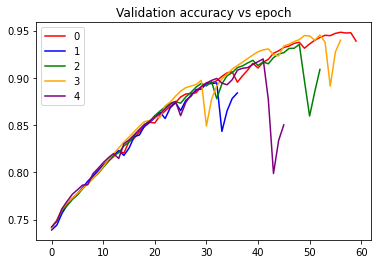

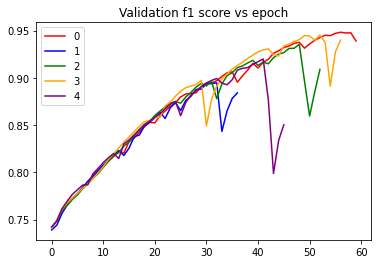

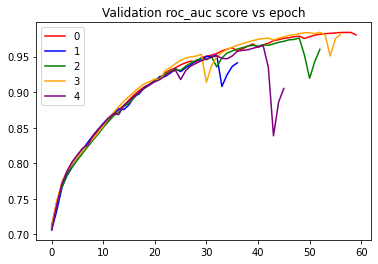

In [18]:
import matplotlib.pyplot as plt

plt.title("Validation accuracy vs epoch")
colors = ["red","blue","green","orange",'purple']
for i in range(0,5):
  x_axis = np.arange(len(val_acc_fin[i]))
  y_axis= val_acc_fin[i]
  plt.plot(x_axis, y_axis, color = colors[i],label=str(i));
  plt.legend()
plt.savefig("/content/drive/My Drive/Colab Notebooks/GNN Benchmarking/Graphs_GNN/PPI/Val_accuracy.png")
plt.show()

plt.title("Validation f1 score vs epoch")
colors = ["red","blue","green","orange",'purple']
for i in range(0,5):
  x_axis = np.arange(len(val_f1_fin[i]))
  y_axis= val_f1_fin[i]
  plt.plot(x_axis, y_axis, color = colors[i],label=str(i));
  plt.legend()
plt.savefig("/content/drive/My Drive/Colab Notebooks/GNN Benchmarking/Graphs_GNN/PPI/Val_f1_score.png")
plt.show()


plt.title("Validation roc_auc score vs epoch")
colors = ["red","blue","green","orange",'purple']
for i in range(0,5):
  x_axis = np.arange(len(val_roc_auc_fin[i]))
  y_axis= val_roc_auc_fin[i]
  plt.plot(x_axis, y_axis, color = colors[i],label=str(i));
  plt.legend()
plt.savefig("/content/drive/My Drive/Colab Notebooks/GNN Benchmarking/Graphs_GNN/PPI/Val_roc_auc_score.png")
plt.show()


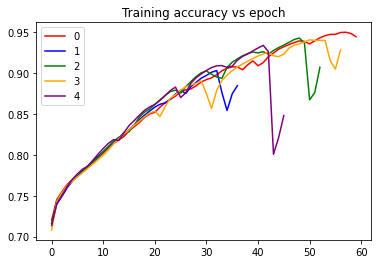

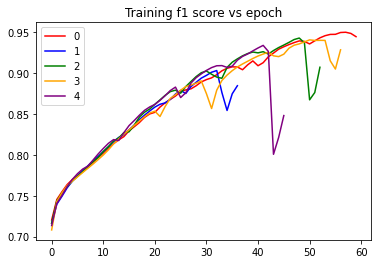

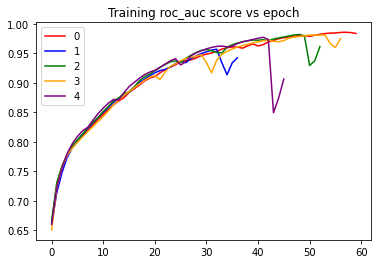

In [19]:
import matplotlib.pyplot as plt

plt.title("Training accuracy vs epoch")
colors = ["red","blue","green","orange",'purple']
for i in range(0,5):
  x_axis = np.arange(len(train_acc_fin[i]))
  y_axis= train_acc_fin[i]
  plt.plot(x_axis, y_axis, color = colors[i],label=str(i));
  plt.legend()
plt.savefig("/content/drive/My Drive/Colab Notebooks/GNN Benchmarking/Graphs_GNN/PPI/Train_accuracy.png")
plt.show()

plt.title("Training f1 score vs epoch")
colors = ["red","blue","green","orange",'purple']
for i in range(0,5):
  x_axis = np.arange(len(train_f1_fin[i]))
  y_axis= train_f1_fin[i]
  plt.plot(x_axis, y_axis, color = colors[i],label=str(i));
  plt.legend()
plt.savefig("/content/drive/My Drive/Colab Notebooks/GNN Benchmarking/Graphs_GNN/PPI/Train_f1_score.png")
plt.show()


plt.title("Training roc_auc score vs epoch")
colors = ["red","blue","green","orange",'purple']
for i in range(0,5):
  x_axis = np.arange(len(train_roc_auc_fin[i]))
  y_axis= train_roc_auc_fin[i]
  plt.plot(x_axis, y_axis, color = colors[i],label=str(i));
  plt.legend()
plt.savefig("/content/drive/My Drive/Colab Notebooks/GNN Benchmarking/Graphs_GNN/PPI/Train_roc_auc_score.png")
plt.show()


In [21]:
model.load_state_dict(torch.load(config['path']+f'model_{fold}'))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, mode='max', verbose=True) #scheduler_on='valid_acc'

FileNotFoundError: ignored